In [1]:
import tensorflow as tf 
import numpy as np
import math

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def batch_generator(x,y, batch_size):
    X_all = x
    y_all = y
    data_len = len(X_all)  
    idx = np.arange(data_len)
    np.random.shuffle(idx)
    X_shuf = np.zeros(X_all.shape)
    Y_shuf = np.zeros(y_all.shape)
    for i in range(data_len):
        X_shuf[i] = X_all[idx[i]]
        Y_shuf[i] = y_all[idx[i]]
    X_all_padded = np.concatenate([X_shuf, X_shuf[:batch_size]], axis=0)
    y_all_padded = np.concatenate([Y_shuf, Y_shuf[:batch_size]], axis=0)
    x_batched = []
    y_batched = []
    for slice_i in range(int(math.ceil(data_len / batch_size))):
        idx = slice_i * batch_size
        X_batch = X_all_padded[idx:idx + batch_size]
        y_batch = y_all_padded[idx:idx + batch_size]
        y_batch = y_batch.astype(np.float32)
        x_batched.append(X_batch)
        y_batched.append(y_batch)
    return (x_batched, y_batched)

In [12]:
def conv(x_):
    conv1 = tf.layers.conv2d(
            inputs=x_,
            filters=32,  # number of filters
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu)
    
    pool1 = tf.layers.max_pooling2d(inputs=conv1, 
                                    pool_size=[2, 2], 
                                    strides=2)  # convolution stride
    
    conv2 = tf.layers.conv2d(
            inputs=pool1,
            filters=64, # number of filters
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, 
                                    pool_size=[2, 2], 
                                    strides=2)  # convolution stride
    conv3 = tf.layers.conv2d(
            inputs=pool2,
            filters=128, # number of filters
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu)
    
    pool3 = tf.layers.max_pooling2d(inputs=conv3, 
                                    pool_size=[2, 2], 
                                    strides=2)  # convolution stride
    conv4 = tf.layers.conv2d(
            inputs=pool3,
            filters=256, # number of filters
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu)
    
    pool4 = tf.layers.max_pooling2d(inputs=conv4, 
                                    pool_size=[2, 2], 
                                    strides=2)  # convolution stride
    conv5 = tf.layers.conv2d(
            inputs=pool4,
            filters=512, # number of filters
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu)
    
    pool5 = tf.layers.max_pooling2d(inputs=conv5, 
                                    pool_size=[2, 2], 
                                    strides=2)  # convolution stride
    
#     conv6 = tf.layers.conv2d(
#             inputs=pool5,
#             filters=1028, # number of filters
#             kernel_size=[5, 5],
#             padding="same",
#             activation=tf.nn.relu)
    
#     pool6 = tf.layers.max_pooling2d(inputs=conv6, 
#                                     pool_size=[2, 2], 
#                                     strides=2)  # convolution stride
    
    pool_flat = tf.contrib.layers.flatten(pool5, scope='pool2flat')
    dense = tf.layers.dense(inputs=pool_flat, units=500, activation=tf.nn.relu)
    logits = tf.layers.dense(inputs=dense, units=3755)
    return logits


def apply_classification_loss(model_function):
    with tf.Graph().as_default() as g:
        with tf.device("/cpu:0"):  # use gpu:0 if on GPU
            x_ = tf.placeholder(tf.float32, [None, 58, 58, 3])
            y_ = tf.placeholder(tf.int32, [None])
            drop_out = tf.placeholder(tf.float32)
            y_logits = model_function(x_)
            
            y_dict = dict(labels=y_, logits=y_logits)
            losses = tf.nn.sparse_softmax_cross_entropy_with_logits(**y_dict)
            cross_entropy_loss = tf.reduce_mean(losses)
            # best for 100 class
#             trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
            trainer = tf.train.AdamOptimizer(learning_rate=0.001)
            train_op = trainer.minimize(cross_entropy_loss)
            
            y_pred = tf.argmax(tf.nn.softmax(y_logits), axis=1)
            correct_prediction = tf.equal(tf.cast(y_pred, tf.int32), y_)
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    model_dict = {'graph': g, 'inputs': [x_, y_, drop_out], 'train_op': train_op,
                  'accuracy': accuracy, 'loss': cross_entropy_loss}
    
    return model_dict

In [13]:
def train_model(model_dict, epoch_n, print_every, xtr,ytr,xte,yte, drop_out):
    with model_dict['graph'].as_default(), tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        loss = []
        accuracy = []
        for epoch_i in range(epoch_n):
            for i in range(len(xtr)):
                x_train_batch = xtr[i]
                y_train_batch = ytr[i]
                train_feed_dict = dict(zip(model_dict['inputs'][:2], [x_train_batch,y_train_batch]))
                train_feed_dict[model_dict['inputs'][2]] = drop_out
                sess.run(model_dict['train_op'], feed_dict=train_feed_dict)
                if epoch_i % print_every == 0:
                    for j in range(len(xte)):
                        x_test_batch = xte[j]
                        y_test_batch = yte[j]
                        test_feed_dict = dict(zip(model_dict['inputs'], [x_test_batch, y_test_batch]))
                        to_compute = [model_dict['loss'], model_dict['accuracy']]
                        result = sess.run(to_compute, test_feed_dict)
                        loss.append(result[0])
                        accuracy.append(result[1])
                        print(result[0], ', ', result[1])
                        loss_ave = np.mean(loss)
                        acc_ave = np.mean(accuracy)
#                         print(loss_ave, ', ', acc_ave)
        return (loss, accuracy)

In [14]:
x_te = np.load('./data/image_data_te10.npy')
y_te = np.load('./data/image_label_te10.npy')
x_tr = np.load('./data/image_data_te10.npy')
y_tr = np.load('./data/image_label_te10.npy')



Xtr_, ytr_ = batch_generator(x_tr ,y_tr, 256)
Xte_, yte_ = batch_generator(x_te ,y_te, 256)


model_dict = apply_classification_loss(conv)
# best for 100 class
# train_model(model_dict, epoch_n=100000, print_every=10, xtr = Xtr_, ytr = ytr_, xte = Xte_, yte = yte_, drop_out = 0.001)
train_model(model_dict, epoch_n=100000, print_every=10, xtr = Xtr_, ytr = ytr_, xte = Xte_, yte = yte_, drop_out = 0.0001)

print('done')

3.949957 ,  0.0859375
3.685204 ,  0.13671875


KeyboardInterrupt: 

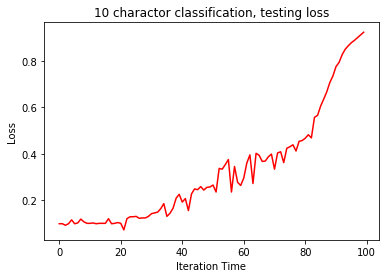

In [13]:
# import matplotlib.pyplot as plt

# plt.title('testing loss')
# plt.xlabel('Iteration Time')
# plt.ylabel('Loss')
# y_label = range(100)
# plt.plot(y_label,loss, 'r', label = '10 classes')
# plt.show()

In [ ]:
# plt.title('testing accuracy')
# plt.xlabel('Iteration Time')
# plt.ylabel('Accuracy')
# y_label = range(100)
# plt.plot(y_label,accuracy, 'b', label = '10 classes')
# plt.show()